# Mane Global Capital Management Test

```
Solution by:

Ali Rizvi

Rizvi_ali@live.com
```

# Section 1: Practical Questions

Create a complete ETL pipeline in Python that uses an open-source iris dataset such Your pipeline should:
1.	The two files contain data and dates. 

    a.	Please calculate 1y growth rates for the dates provided and save data to a csv named quarterly_data. 

    b.	Describe the trend you see in the quarterly data

    c.	Are there any other interesting trends in the data that you think may be of interest?

    d.	What if I asked you how this data would perform over over the next few weeks, can you project based on historical trends?
    
2.	Suppose now you get revised and incremental version of the data file. How would you update your original quarterly data file with the new data? What are some of your initial thoughts when you come across this task and how would you handle them?


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, HTML
import seaborn as sns
from prophet import Prophet

c:\Users\rizvi\Downloads\mane_global_test\timeseries_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## ETL before answering questions

#### data ingestion

In [2]:
#load data
def read_data():
    
    #quarter lables
    df_quarters = pd.read_csv(
        '../input_data/quarter_dates.csv',
        parse_dates=['start_date','end_date','start_date_prior','end_date_prior']
    )

    #daily data
    df = pd.read_excel('../input_data/data.xlsx', parse_dates=['date']).sort_values('date')
    df = df.rename(columns={'index':'index_value'})

    #return as dictionary
    return {'quarters_data':df_quarters, 'daily_data':df}

#reading data files
data_dict = read_data()
df_quarters = data_dict['quarters_data']
df = data_dict['daily_data']


#### Data exploration outcomes

>**Daily Data**

- no missing values
- date range 1Jan2019 to 31oct2024
- 2131 records

> **Quarter labels Data**
- no missing values
- 10 records
- provides specific dates for quarter and PCP (does not follow usual FY monthly dates)
- quarters ranging from 2023q1 to 2025q2
- dates ranging from 2024-02-02 to 2025-06-16
- dates for PCP ranging from 2023-02-03 to 2024-06-17

>**Notes**
- use PCP prior dates for quarter growth comparison
- filter for only the dates provided in quarter labels

## Answers

### Q1.a Growth Rates

In [3]:
#adding end of period index values to provided quarter dates
df_quarters_pcp_growth = (
    df_quarters
    #merge actual quarter eop data
    .merge(
        df.rename(columns={'index_value':'index_val_eoq'})
        ,how='left'
        ,left_on='end_date'
        ,right_on='date'
    )
    #merge prior period data
    .merge(
        df.rename(columns={'index_value':'index_val_eoq_pcp'})
        ,how='left'
        ,left_on='end_date_prior'
        ,right_on='date'
    )
    #select reuiqred columns
    .loc[lambda x: ~x.index_val_eoq.isnull(),['qname','start_date', 'end_date', 'start_date_prior','end_date_prior', 'index_val_eoq','index_val_eoq_pcp']]
    #create growth values
    .assign(q_pcp_growth_perc = lambda x: (x.index_val_eoq/x.index_val_eoq_pcp -1).round(4))
)

#display data
display(df_quarters_pcp_growth)

#export to csv
df_quarters_pcp_growth.to_csv('../output_data/df_quarters_pcp_growth.csv')


,qname,start_date,end_date,start_date_prior,end_date_prior,index_val_eoq,index_val_eoq_pcp,q_pcp_growth_perc
0,20231,2022-12-27,2023-03-20,2021-12-28,2022-03-21,126856.30,151969.11,-0.1652
1,20232,2023-03-22,2023-06-12,2022-03-23,2022-06-13,134106.92,169625.09,-0.2094
2,20233,2023-06-14,2023-09-04,2022-06-15,2022-09-05,154324.08,183184.79,-0.1575
3,20234,2023-09-06,2023-12-24,2022-09-07,2022-12-25,151224.27,19814.00,6.6322
4,20241,2023-12-25,2024-03-18,2022-12-26,2023-03-20,149403.04,126856.30,0.1777
5,20242,2024-03-19,2024-06-10,2023-03-21,2023-06-12,138810.67,134106.92,0.0351
6,20243,2024-06-11,2024-09-02,2023-06-13,2023-09-04,166206.51,154324.08,0.0770


### Q1.b Describing Quarter Growth Trends

Refer to Figure 1 below for visual insights. 

> **Executive Summary**

- 2024Q3 EOQ (end of Quarter) Index of $166.2k
- Net Index gain of ~32% from Q1 ’23  to Q3 ’24 (over seven quarters); index rose from c.a. $126k to $166k  .
- 2023 Q1 to Q3; double digit negative growth against PCP (c.a. –17% to –21%), reflecting tougher PCP comparisons from previous year's highs.
- 2024 Q1 onwards; positive growth against PCP with strong growth in Q1 (+18%), followed by single digit growth in Q2 (+3.5%) and Q3 (+7.7%).
- 2023 Q4 spike is an outlier: Reported +663% 1 year growth is artificial—prior-period index was erroneously low (~19 k), not a genuine market surge.

> **Detailed Analysis**

Overall, the end-of-quarter index has mostly trended upward since Q1 2023, rising from about $126k to a peak of $166k by Q3 2024. The first three quarters of 2023 each saw solid gains—roughly +6 %–15 % quarter-to-quarter, followed by a gradual decline to c.a. 140k by Q2 2024. Q3 2024 saw a strong bounce back, landing at $166k, highest quarter end since the peak of $183k seen in 2022 Q3.

PCP (prior-period-comparable) growth shows negative growth in the first three quarters of 2023 (around –16 % to –21 %). Growth turned positive from Q1 2024 onward, starting with +18% in Q1 2024, then falling to single digits in Q2 2024 (+3.5%), and Q3 2024 (+7.7%).

The Q4 2023 spike (over +660 % 1 Y growth) is misleading and should be considered an outlier. On average the quarter performed at par with PCP. The PCP comparison data for the prior-period index for Q4 2022 was extremely low (around 19 k, versus the typical ~175 k) resulting in the large growth value. PCP comparisons using 7d averages could result in a more accurate representation of the quarter end rather than relying on a single day value. 

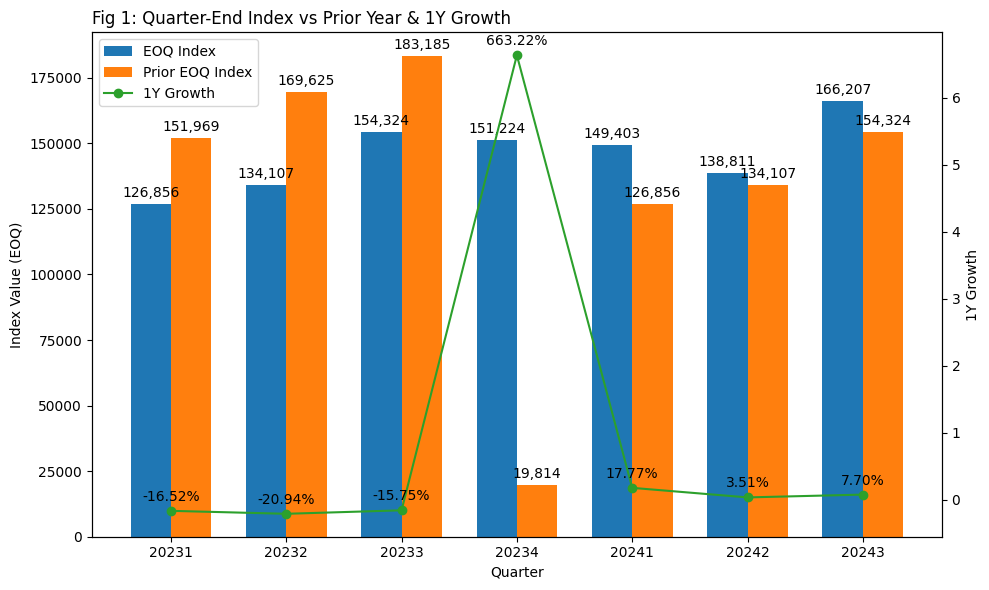

In [4]:

# Plot setup
x = np.arange(len(df_quarters_pcp_growth))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax2 = ax.twinx()

# Bars for index values
bars1 = ax.bar(x - width/2, df_quarters_pcp_growth['index_val_eoq'], width, label='EOQ Index', color='tab:blue')
bars2 = ax.bar(x + width/2, df_quarters_pcp_growth['index_val_eoq_pcp'], width, label='Prior EOQ Index', color='tab:orange')

# Line for growth (plotted on secondary y-axis)
line = ax2.plot(x, df_quarters_pcp_growth['q_pcp_growth_perc'], marker='o', linestyle='-', label='1Y Growth', color='tab:green')

# Data labels on bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:,.0f}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

# Data labels on line
for xi, yi in zip(x, df_quarters_pcp_growth['q_pcp_growth_perc']):
    ax2.annotate(f'{yi:.2%}',
                 xy=(xi, yi),
                 xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')

# Axes labels and title
ax.set_xlabel('Quarter')
ax.set_ylabel('Index Value (EOQ)', color='black')
ax2.set_ylabel('1Y Growth', color='black')
ax.set_xticks(x)
ax.set_xticklabels(df_quarters_pcp_growth['qname'])
ax.set_title('Fig 1: Quarter-End Index vs Prior Year & 1Y Growth', loc='left')

# Legends
lines_labels = ax.get_legend_handles_labels()
lines2_labels = ax2.get_legend_handles_labels()
ax.legend(lines_labels[0] + lines2_labels[0], lines_labels[1] + lines2_labels[1], loc='upper left')

plt.tight_layout()
plt.show()


### Q1.c Trends in Daily Data

**Summary:**

1. Overall trend (excluding Seasonlity) shows a trough in 2022 with index falling under $120k, then rising to c.a. $160k by mid 2021 after which a slight decrease untill 2022 and then a steady upward growth 2023 onwards. (See figure 5)
2. There is evidence of yearly and weekly seasonality (see Figure 5)

    a. Jan seems to be a trough falling c.a. $50k below yearly average while there are peaks in Aug $50k above average and Dec c.a. $150k above yearly average. This can be seen clearly in Figure 3, which shows yearly data plotted against each other. 

    b. Weekly seasonality shows a peak at Saturday and then gradually decreasing to the lowest Index on Thursday.

3. Index Values in the year 2024 seem to have a higher variance compared to prior period showing higher peaks and lower troughs. (see Figure 2)
4. Consistent large outliers in Q3, specifically in the month of Dec, where Index values reach heights of c.a. $800k, c.a. $600k above yearly average. (see Figure 2)

index             index_pcp           
              mean     median       mean     median
qname                                              
20231.0  117,966.7  115,857.6  121,457.3  112,278.0
20232.0  144,827.6  136,592.4  150,245.9  147,062.3
20233.0  167,054.3  160,115.4  157,582.1  149,011.2
20234.0  191,899.2  165,455.1  174,572.4  156,870.1
20241.0  126,280.7  116,083.5  118,400.3  116,023.8
20242.0  152,480.3  145,807.4  144,546.2  135,954.7
20243.0  175,753.0  169,241.8  166,585.7  159,268.5
20244.0  143,364.6  132,105.2  188,761.9  169,976.1

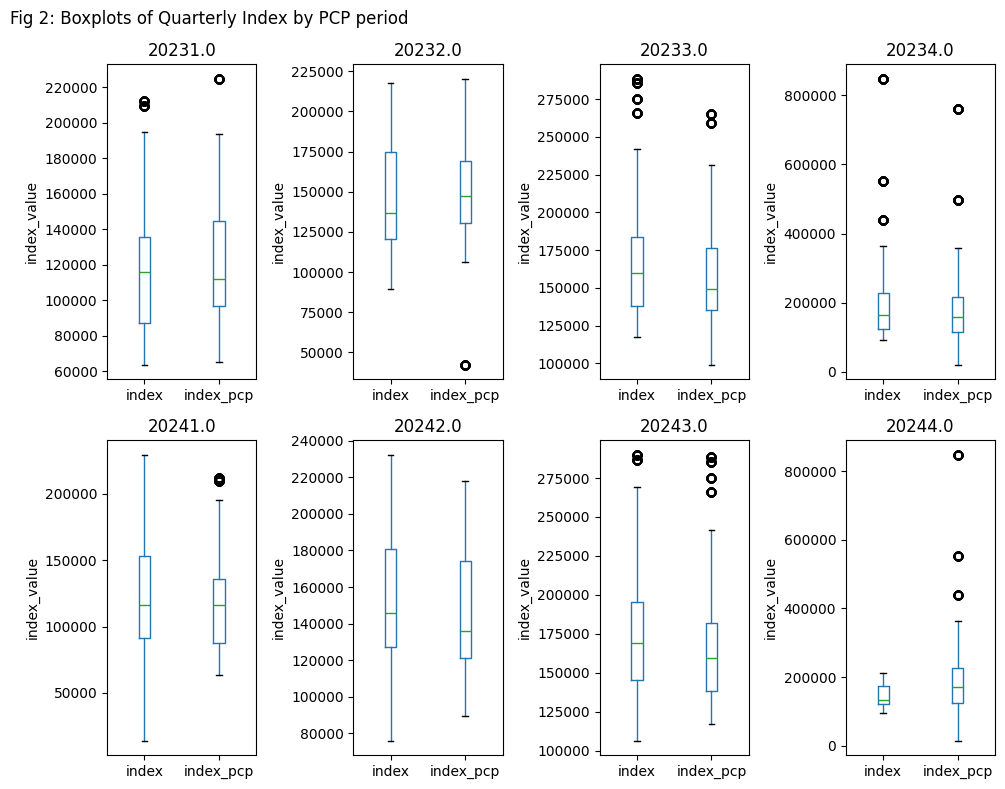

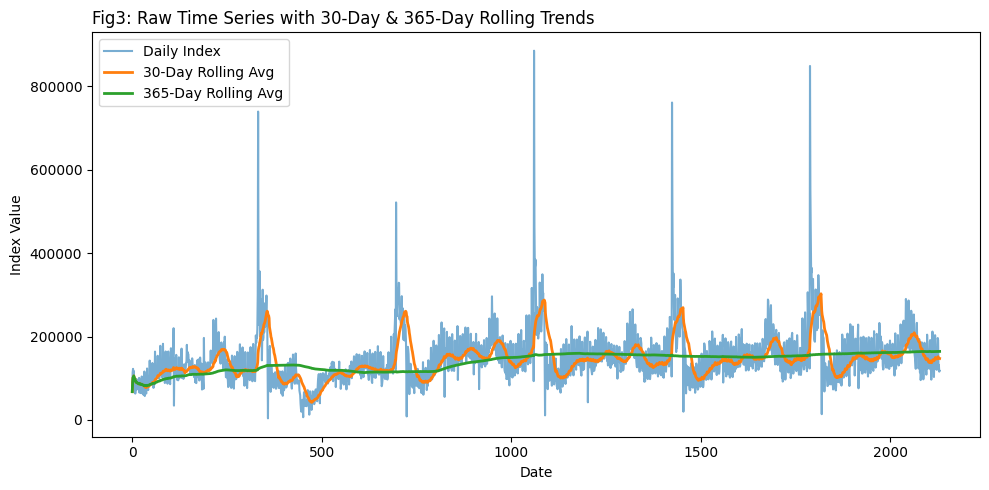

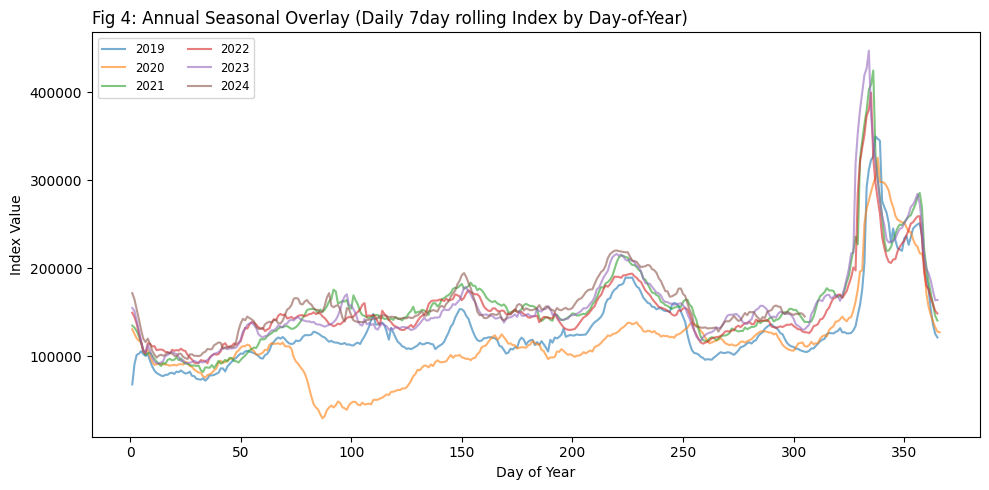

In [5]:
######################################################################################
# view mean/median/boxplot of each quarter to understand its data
######################################################################################

df_labeled = df.copy()

#add quarter and future pcp quarter labels to daily data 
#also add a flag to show end of quarter date
for i,r in df_quarters.iterrows():
    df_labeled.loc[df_labeled.date.between(r.start_date, r.end_date, inclusive='both'), 'qname'] = r.qname
    df_labeled.loc[df_labeled.date.between(r.start_date_prior, r.end_date_prior, inclusive='both'), 'future_pcp_qname'] = r.qname
    df_labeled.loc[df_labeled.date == r.end_date, 'f_eoq'] = 1

#for each quarter obtain its index and pcp index
t = df_labeled.copy()
t1 = t[df_labeled.qname.notnull()][[ 'index_value', 'qname']].rename(columns={'index_value':'index'})
t2 = t[df_labeled.future_pcp_qname.notnull()][[ 'index_value', 'future_pcp_qname']].rename(columns={'future_pcp_qname':'qname', 'index_value':'index_pcp'})
tmpj = t1.merge(t2, on='qname')

#display data in table

display(HTML("<h3>Table 1: Index means and medians by Quarters</h3>"))
display(tmpj.groupby('qname').agg(['mean','median']).map(lambda x: '{:,.1f}'.format(x)))
print('\n'*3)

# Create a 2-row x 4-column grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 8), sharey=False)
axes_flat = axes.flatten()

# Loop through each subplot and DataFrame and plot boxplot
for i, ax in enumerate(axes_flat):
    q = tmpj.qname.unique()[i]
    tmpj.loc[tmpj.qname == q, ['index', 'index_pcp']].boxplot(ax=ax, grid=False)
    ax.set_title(q)
    ax.set_xlabel('')           
    ax.set_ylabel('index_value')  

# adding title
fig.suptitle('Fig 2: Boxplots of Quarterly Index by PCP period', x=0.0, horizontalalignment='left')
plt.tight_layout()


######################################################################################
# view time series by moving averages to understand trend
######################################################################################

plt.figure(figsize=(10, 5))
plt.plot(df.index, df['index_value'], label='Daily Index', color='tab:blue', alpha=0.6)

# 30-day and 365-day rolling averages to visualize short- vs. long-run trend:
df['7d_roll']  = df['index_value'].rolling(window=7,  min_periods=1).mean()
df['30d_roll']  = df['index_value'].rolling(window=30,  min_periods=1).mean()
df['365d_roll'] = df['index_value'].rolling(window=365, min_periods=1).mean()
plt.plot(df.index, df['30d_roll'],  label='30-Day Rolling Avg',  color='tab:orange', linewidth=2)
plt.plot(df.index, df['365d_roll'], label='365-Day Rolling Avg', color='tab:green',  linewidth=2)

plt.xlabel('Date')
plt.ylabel('Index Value')
plt.title('Fig3: Raw Time Series with 30-Day & 365-Day Rolling Trends', loc='left')
plt.legend()
plt.tight_layout()
plt.show()


######################################################################################
# view overlapped time series by moving averages to understand trend
######################################################################################

#set date as index 
df.set_index('date', inplace=True)
#Resample to daily frequency and interpolate missing days (convert to timeseries)
df = df.asfreq('D').interpolate(method='time')

# Create helper columns to do “by day-of-year” and “by day-of-week” plots:
df['year']      = df.index.year
df['month_day']  = df.index.month + df.index.day
df['dayofyear'] = df.index.dayofyear
df['week'] = df.index.isocalendar().week
df['dayofweek'] = df.index.dayofweek


# Annual Overlay: plot 7d roll avg index by year to see yearly seasonality
plt.figure(figsize=(10, 5))
for yr in sorted(df['year'].unique()):
    subset = df[df['year'] == yr]
    plt.plot(subset['dayofyear'], subset['7d_roll'], label=str(yr), alpha=0.6)
plt.xlabel('Day of Year')
plt.ylabel('Index Value')
plt.title('Fig 4: Annual Seasonal Overlay (Daily 7day rolling Index by Day-of-Year)', loc='left')
plt.legend(loc='upper left', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()



19:34:34 - cmdstanpy - INFO - Chain [1] start processing
19:34:35 - cmdstanpy - INFO - Chain [1] done processing


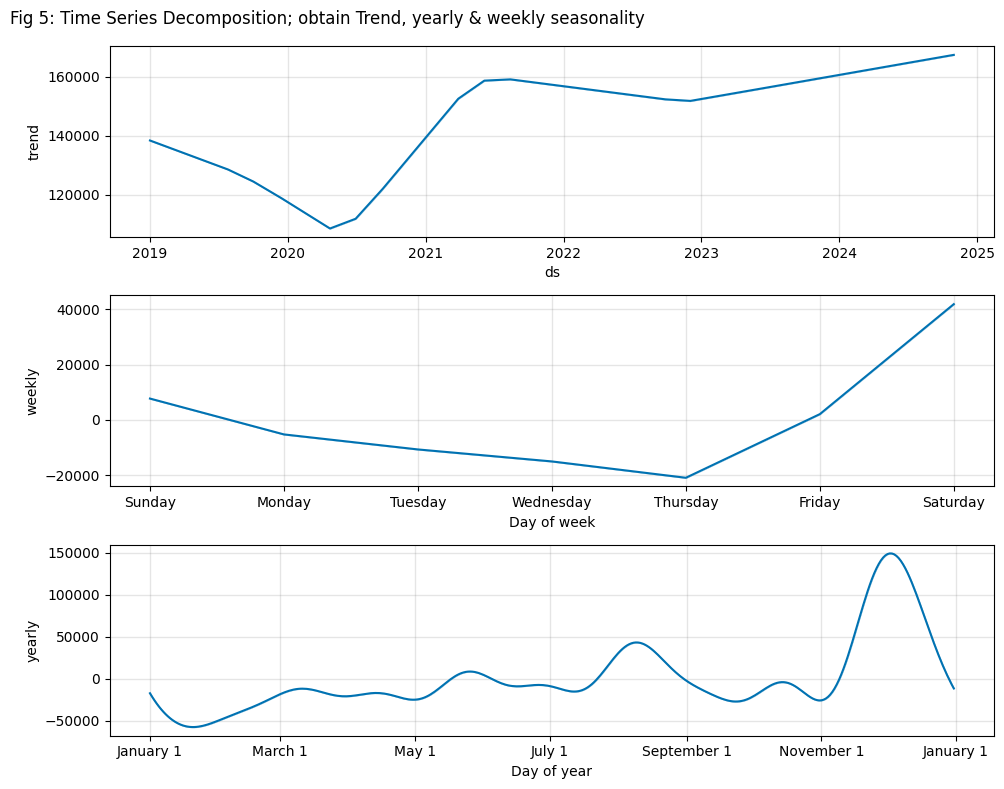

In [6]:
######################################################################################
# Create TS model using prophet and use its built in decomposition feature
######################################################################################

# createing a time series model from the library prophet “ds” & “y”
df_prophet = df.reset_index()[['date','index_value']].rename(columns={'date':'ds','index_value':'y'})

# create model with weekly & yearly seasonality enabled
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

# Fit on the historical data
m.fit(df_prophet)

# use models built-in decomposition plot:
future_for_components = m.make_future_dataframe(periods=0)  
comp_fig = m.plot_components(m.predict(future_for_components))
comp_fig.set_size_inches(10, 8)
plt.suptitle('Fig 5: Time Series Decomposition; obtain Trend, yearly & weekly seasonality', x=0.0, horizontalalignment='left')
plt.tight_layout()
plt.show()


### Q1.c Forecasting 8 Weeks data

Given the data is in time series we can use libraries suited for forecasting. 
1. the prophet library does that quite well (which is used to answer this question) - with minimal user input. 
2. if a more detailed projection is needed we can use libraries like STL decomposition we can really fine tune our predictions to incorporate what we're after - but requires knowledge of time series modelling. 

Future projections are shown in figure 8, while a snaphot of the last 10 records of the forecast are provided in Table 2. 

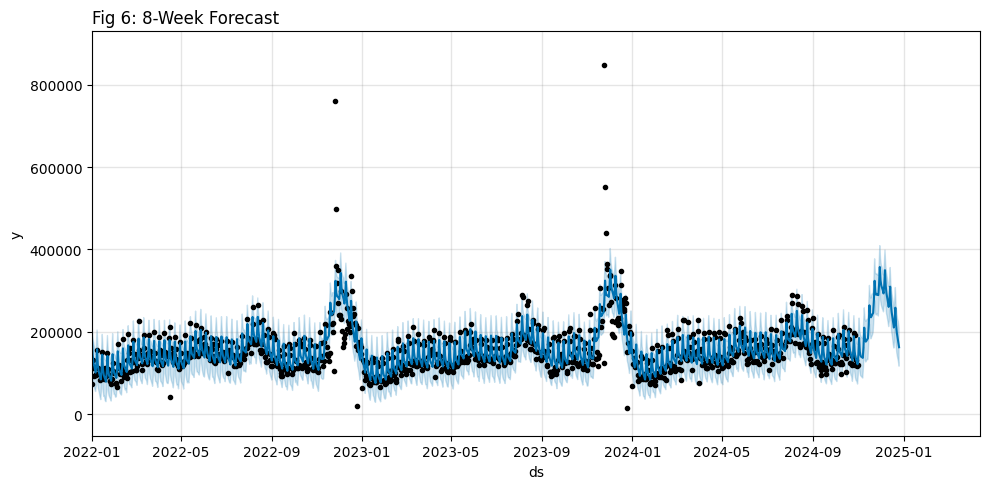

,yhat,yhat_lower,yhat_upper
ds,,,
2024-12-17,235082.895066,188599.861647,285551.255716
2024-12-18,223332.289084,171778.721956,272970.363429
2024-12-19,210033.123504,160286.978913,256331.127039
2024-12-20,225733.798049,176988.283176,271989.209334
2024-12-21,258318.346321,206483.385144,307244.710999
2024-12-22,217105.957107,166747.793193,261888.601784
2024-12-23,197258.970546,147477.391628,245734.684271
2024-12-24,185155.597323,137610.716856,231415.298521
2024-12-25,174379.086985,128919.365210,224472.577643


In [7]:
# Create dataFrame extending 56 days (8 weeks) ahead of our last historical date
future = m.make_future_dataframe(periods=56, freq='D')

# use prophet to create forecast
forecast = m.predict(future)

# Plot the full forecast (history + 56-day ahead + uncertainty bands)
fig_forecast = m.plot(forecast)
fig_forecast.set_size_inches(10, 5)

#filter to show history from last 2 years only
ax = fig_forecast.gca()  
ax.set_xlim(left=pd.Timestamp('2022-01-01'))

#plotting data
plt.title('Fig 6: 8-Week Forecast', loc='left')
plt.tight_layout()
plt.show()

# Show just the forecast data for the final 56 days
fc_56 = forecast.set_index('ds').loc[df.index.max() + pd.Timedelta(days=1) : ]
display(HTML("<h3>Table 2: last 10 records of forecasted data </h3>"))
display(fc_56[['yhat','yhat_lower','yhat_upper']].tail(10))


### Q2

When new data arrives, my initial thoughts prior to proceeding with data injestive would be:


**Data Versioning & Avoiding Duplication**: Create clear indication of whats new vs old data. Rather than replacing old data, versioning could allow for retain older data history. This could be done with versioning file names or adding columns such as valid_from and valid_to dates. 

**Data Uniqueness**: Avoid duplicates on primary keys in case prior quarter data is updated or revised. 

**Allowing for Rollback**: There needs to be a way to roll back to the previous state in case the new file has errors. This can be done using file names or flagging for new data being appended or using a database with transaction logs where I can revert the last transaction.

**Schema Compatibility**: Check whether the revised file has exactly the same columns as the original. New column formatting, Column names, or addition or subtraction of columns can result in data errors. The code, or script logic used for data ingestion should allow for flagging and error handling to prompt the user of these changes. The data ingestion code will also need to be updated in case this occurs. 

**Validation & Quality Checks**: In addition to schema compatibility, validation and quality checks need to be performance to see if data is accurate. This could include conducting checks on quarters covered in the data set, missing values etc. to ensure that the data being added makes sense. 

**Automation**: If quarter data revisions have a specific cadence, or are performed regularly, automation of the data ingestion should be done to avoid manual data entry errors. This automation could be done using python and tools like MLflow etc to run the script whenever new data arrives. 
